# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks
# !ls

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Install libraries
!pip install mne
!pip install pyriemann
!pip install MOABB
!pip install  scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# References
- EEGANet: Removal of Ocular Artifact from the EEG Signal Using Generative Adversarial Networks
    - https://ieeexplore.ieee.org/document/9627782
    - https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/SRGAN
    - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/srgan
- Datasets
    - http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014004.html#moabb.datasets.BNCI2014004
- Notes
    - 

## Import libraries and read files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
from mne.preprocessing import ICA
from sklearn.preprocessing import MinMaxScaler
import pywt
import scipy
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.neighbors import KDTree

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")

## Load data

In [ ]:
n_event_ids = 20
selected_data_len = 2000

# 60 events/ 1 run/ 3 sessions/ 1 subject
batch_size = 10
n_subjs = 20
events_per_run = 20
runs_per_session = 1
sessions_for_train = 2
sessions_for_eval = 1
events_per_subj_for_train = int(events_per_run * runs_per_session * sessions_for_train)
events_per_subj_for_eval = int(events_per_run * runs_per_session * sessions_for_eval)
train_split = int(events_per_subj_for_train * 0.8)

list_subjs_names = [str(f"Subject {i+1}") if i < n_subjs else str(f"All Subjects")  for i in range(n_subjs+1)]
# list_subjs_names

In [ ]:
EOG_ref = "wICA_without_ref"
ECG_ref = None

# LOAD EEG DATA
train_eeg = np.load(f'Datasets/Shin2017A/npy_files/train_eeg_{EOG_ref}-{ECG_ref}.npy')
eval_eeg = np.load(f'Datasets/Shin2017A/npy_files/eval_eeg_{EOG_ref}-{ECG_ref}.npy')
# LOAD EVENT
train_events = np.load(f'Datasets/Shin2017A/npy_files/train_events.npy')
eval_events = np.load(f'Datasets/Shin2017A/npy_files/eval_events.npy')

In [ ]:
# Events
train_events = train_events.copy()
eval_events = eval_events.copy()

list_epochs_modeling = [train_eeg,
                        eval_eeg]

print(train_events[:,-1].shape)
print(train_events[:,-1][:10])
print(eval_events[:,-1].shape)
print(eval_events[:,-1][:10])

for e_type in list_epochs_modeling:
    # print(e_type.get_data().shape)
    print(e_type.shape)
    print(np.max(e_type))
    print(np.min(e_type))
    print('-'*100)

# print(np.all(train_cont_eeg == train_denoised_eeg))

(800,)
[1 2 1 2 1 2 1 2 2 1]
(400,)
[1 2 2 1 2 1 1 2 1 2]
(800, 30, 2000)
0.9129697680473328
-0.8596015572547913
----------------------------------------------------------------------------------------------------
(400, 30, 2000)
0.9012501835823059
-0.6993433237075806
----------------------------------------------------------------------------------------------------


# Classification
- 01 = CSP + SVM
- 02 = CSP + LDA
- 03 = EEGNet
    - Note of EEGNET's problems
        - FC Layer
            x = x.reshape(-1, 4*2*7)
        - Label must start with 0
    - Data format:
        Datatype - float32 (both X and Y) <br>
        X.shape - (#samples, 1, #timepoints,  #channels) <br>
        Y.shape - (#samples)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def data_for_EEGNET(input_epochs):
    # X.shape - (#epochs, 1, #timepoints, #channels)
    output_epochs = []
    for e_epoch in input_epochs:
        e_epoch = e_epoch.transpose()
        e_epoch = np.expand_dims(e_epoch,axis=0)
        # print(e_epoch.shape)
        output_epochs.append(e_epoch)
        # break
    return np.array(output_epochs).astype('float32')

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        # Modify self.T, self.fc1 
        super(EEGNet, self).__init__()
        self.T = 2000 # #samples per task
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 30), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*125, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 4*2*125)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 2000, 30)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

tensor([[0.3603]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

## Run

In [ ]:
for idx_e_subj in range(3):
    train_split = int(events_per_subj_for_train * 0.8)
    # Assign data and label for Training, Validation, Evaluation

    start_idx_train = int(idx_e_subj * events_per_subj_for_train)
    end_idx_train = start_idx_train + int(events_per_subj_for_train * 0.8)
    start_idx_val = end_idx_train
    end_idx_val = int((idx_e_subj+1) * events_per_subj_for_train)
    start_idx_eval = int((idx_e_subj)*events_per_subj_for_eval)
    end_idx_eval  = int((idx_e_subj+1)*events_per_subj_for_eval)

    print(f"start_idx_train: {start_idx_train}")
    print(f"end_idx_train: {end_idx_train}")
    print(f"start_idx_val: {start_idx_val}")
    print(f"end_idx_val: {end_idx_val}")
    print(f"start_idx_eval: {start_idx_eval}")
    print(f"end_idx_eval: {end_idx_eval}")
    print('='*100)

    # break

start_idx_train: 0
end_idx_train: 32
start_idx_val: 32
end_idx_val: 40
start_idx_eval: 0
end_idx_eval: 20
start_idx_train: 40
end_idx_train: 72
start_idx_val: 72
end_idx_val: 80
start_idx_eval: 20
end_idx_eval: 40
start_idx_train: 80
end_idx_train: 112
start_idx_val: 112
end_idx_val: 120
start_idx_eval: 40
end_idx_eval: 60


In [ ]:
best_test_subjs = []

for idx_e_subj, e_subj in enumerate(list_subjs_names):
    print(e_subj)

    if e_subj != 'All Subjects':
        # Assign data and label for Training, Validation, Evaluation
        start_idx_train = int(idx_e_subj * events_per_subj_for_train)
        end_idx_train = start_idx_train + int(events_per_subj_for_train * 0.8)
        start_idx_val = end_idx_train
        end_idx_val = int((idx_e_subj+1) * events_per_subj_for_train)
        start_idx_eval = int((idx_e_subj)*events_per_subj_for_eval)
        end_idx_eval  = int((idx_e_subj+1)*events_per_subj_for_eval)
                        
        X_train = train_eeg[start_idx_train:end_idx_train,:,:]
        y_train = train_events[start_idx_train:end_idx_train,-1]
        X_val = train_eeg[start_idx_val:end_idx_val,:,:]
        y_val = train_events[start_idx_val:end_idx_val,-1]
        X_test = eval_eeg[start_idx_eval:end_idx_eval,:,:]
        y_test = eval_events[start_idx_eval:end_idx_eval,-1]

    elif e_subj == 'All Subjects':
        # Assign data and label for Training, Validation, Evaluation
        start_idx_train = int(0)
        end_idx_train = start_idx_train + int(events_per_subj_for_train * 0.8 * n_subjs)
        start_idx_val = end_idx_train
        end_idx_val = int(events_per_subj_for_train * n_subjs)
        start_idx_eval = int(0)
        end_idx_eval  = int(events_per_subj_for_eval * n_subjs)

        X_train = train_eeg[start_idx_train:end_idx_train,:,:]
        y_train = train_events[start_idx_train:end_idx_train,-1]
        X_val = train_eeg[start_idx_val:end_idx_val,:,:]
        y_val = train_events[start_idx_val:end_idx_val,-1]
        X_test = eval_eeg
        y_test = eval_events[:,-1]

    # Modify the input data and its label
    X_train = data_for_EEGNET(X_train)
    X_val = data_for_EEGNET(X_val)
    X_test = data_for_EEGNET(X_test)

    y_train = y_train - 1 # Start with 0
    y_val = y_val - 1 # Start with 0
    y_test = y_test - 1 # Start with 0

    print(f"start_idx_train: {start_idx_train}")
    print(f"end_idx_train: {end_idx_train}")
    print(f"start_idx_val: {start_idx_val}")
    print(f"end_idx_val: {end_idx_val}")
    print(f"start_idx_eval: {start_idx_eval}")
    print(f"end_idx_eval: {end_idx_eval}")

    print(y_train[:10])
    print(y_val[:10])
    print(y_test[:10])

    print('-'*100)
    
    # Assign a model and its hyperparameters
    # del net
    net = EEGNet().cuda(0)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters())

    list_training_loss = []
    list_train_performance = []
    list_valid_performance = []
    list_test_performance = []

    for epoch in range(100):  # loop over the dataset multiple times
        print("\nEpoch ", epoch)
        net.train()
        running_loss = 0.0
        for i in range(int((len(X_train)/batch_size-1))):
            s = i*batch_size
            e = i*batch_size+batch_size
            
            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
            
            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            running_loss += loss.item()
            
        # Validation accuracy
        net.eval()
        params = ["acc", "auc", "fmeasure"]
        print(params)

        e_train_performance = evaluate(net, X_train, y_train, params)
        e_valid_performance = evaluate(net, X_val, y_val, params)
        e_test_performance = evaluate(net, X_test, y_test, params)

        print("Training Loss ", running_loss)
        print("Train - ", e_train_performance)
        print("Validation - ", e_valid_performance)
        print("Test - ", e_test_performance)

        list_training_loss.append(running_loss)
        list_train_performance.append(e_train_performance)
        list_valid_performance.append(e_valid_performance)
        list_test_performance.append(e_test_performance)

    list_training_loss = np.array(list_training_loss)
    list_train_performance = np.array(list_train_performance)
    list_valid_performance = np.array(list_valid_performance)
    list_test_performance = np.array(list_test_performance)

    best_acc = np.argmax(list_test_performance[:,0])
    print(f"Epoch with best accuracy is {best_acc}")
    best_test_performance = list_test_performance[best_acc,:]
    best_test_subjs.append(best_test_performance)
    print('='*50 + 'END OF SUBJECT {idx_e_subj+1}' + '='*50)


Streaming output truncated to the last 5000 lines.

Epoch  99
['acc', 'auc', 'fmeasure']
Training Loss  0.0103688626550138
Train -  [0.78125, 0.89453125, 0.7741935483870969]
Validation -  [0.875, 0.9375, 0.888888888888889]
Test -  [0.5, 0.53, 0.5833333333333334]
Epoch with best accuracy is 4
==================================================END OF SUBJECT {idx_e_subj+1}==================================================
Subject 15
start_idx_train: 560
end_idx_train: 592
start_idx_val: 592
end_idx_val: 600
start_idx_eval: 280
end_idx_eval: 300
[0 1 0 1 0 1 1 0 1 0]
[1 0 0 1 0 1 0 1]
[1 0 0 1 1 0 1 0 0 1]
----------------------------------------------------------------------------------------------------

Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  1.5689383745193481
Train -  [0.5, 0.4609375, nan]
Validation -  [0.375, 0.5, nan]
Test -  [0.45, 0.48, nan]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  1.3625558614730835
Train -  [0.53125, 0.53125, 0.11764705882352941]
Validatio

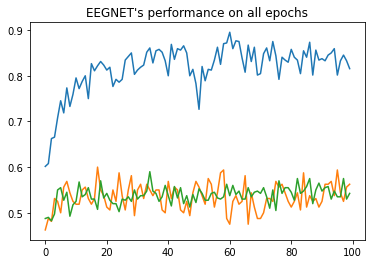

In [ ]:
plt.plot(list_train_performance[:,0])
plt.plot(list_valid_performance[:,0])
plt.plot(list_test_performance[:,0])
plt.title("EEGNET's performance on all epochs")
plt.show()

In [ ]:
best_test_subjs = np.array(best_test_subjs)
best_test_subjs

array([[0.7       , 0.65      , 0.7       ],
       [0.55      , 0.61      , 0.47058824],
       [0.55      , 0.45      , 0.52631579],
       [0.75      , 0.73      , 0.70588235],
       [0.65      , 0.51      , 0.46153846],
       [0.75      , 0.75      , 0.76190476],
       [0.65      , 0.66      , 0.63157895],
       [0.7       , 0.6       , 0.72727273],
       [0.75      , 0.79      , 0.8       ],
       [0.65      , 0.54      , 0.69565217],
       [0.55      , 0.48      , 0.68965517],
       [0.55      , 0.46      , 0.68965517],
       [0.8       , 0.82      , 0.8       ],
       [0.55      , 0.51      , 0.66666667],
       [0.7       , 0.65      , 0.66666667],
       [0.65      , 0.49      , 0.58823529],
       [0.65      , 0.56      , 0.58823529],
       [0.65      , 0.75      , 0.69565217],
       [0.65      , 0.63      , 0.69565217],
       [0.55      , 0.34      , 0.18181818],
       [0.59      , 0.602925  , 0.58163265]])

In [ ]:
best_test_subjs.shape

(21, 3)

# Save data

In [ ]:
# Change to Percentage
best_test_subjs = best_test_subjs * 100
# Create DataFrame
df_model_metrics = pd.DataFrame(data=best_test_subjs, 
                      index= list_subjs_names,
                      columns=params)

df_model_metrics

,acc,auc,fmeasure
Subject 1,70.0,65.0000,70.000000
Subject 2,55.0,61.0000,47.058824
Subject 3,55.0,45.0000,52.631579
Subject 4,75.0,73.0000,70.588235
Subject 5,65.0,51.0000,46.153846
Subject 6,75.0,75.0000,76.190476
Subject 7,65.0,66.0000,63.157895
Subject 8,70.0,60.0000,72.727273
Subject 9,75.0,79.0000,80.000000
Subject 10,65.0,54.0000,69.565217


In [ ]:
# df_model_metrics.to_csv(path_or_buf=f'result/MI/MI_acc_EEGNET-{EOG_ref}-{ECG_ref}.csv', 
#                         sep=',', float_format=None)